In [4]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt


chessboard_size = (8, 6)
square_size = 30

# 3D object points
objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
objp *= square_size

objpoints = []
imgpoints = []

images = glob.glob('../custom_dataset/*.jpg')

for file_name in images:
    img = cv2.imread(file_name)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Chessboard Corners
    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)

    if ret:
        objpoints.append(objp)
        corners_refined = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
        imgpoints.append(corners_refined)
        cv2.drawChessboardCorners(img, chessboard_size, corners_refined, ret)
        cv2.imshow('Corners', img)
        cv2.waitKey(500)
    else:
        print(f"Corners not found in {file_name}")

cv2.destroyAllWindows()

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# 3.1 - Intrinsic Camera Parameters

In [5]:
print("Intrinsic Matrix (K):")
print(mtx)

# Extract intrinsic parameters
fx, fy = mtx[0, 0], mtx[1, 1]
print(f"Focal Lengths: fx = {fx:.2f}, fy = {fy:.2f} pixels")

cx, cy = mtx[0, 2], mtx[1, 2]
print(f"Principal Point: cx = {cx:.2f}, cy = {cy:.2f} pixels")

skew = mtx[0, 1]
print(f"Skew Parameter: {skew:.2f}")

print(f"Reprojection Error: {ret:.4f} pixels")

Intrinsic Matrix (K):
[[1.30650443e+03 0.00000000e+00 6.31947651e+02]
 [0.00000000e+00 1.31941647e+03 5.31411939e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Focal Lengths: fx = 1306.50, fy = 1319.42 pixels
Principal Point: cx = 631.95, cy = 531.41 pixels
Skew Parameter: 0.00
Reprojection Error: 1.8691 pixels


# 3.2 - Extrinsic Camera Parameters

In [6]:
print("\nExtrinsic Parameters for First 2 Images:")
for i in range(min(2, len(rvecs))):
    R, _ = cv2.Rodrigues(rvecs[i])
    t = tvecs[i]
    print(f"\nImage {i+1}:")
    print("Rotation Matrix (R):")
    print(R)
    print("Translation Vector (t):")
    print(t)


Extrinsic Parameters for First 2 Images:

Image 1:
Rotation Matrix (R):
[[ 0.07173739  0.99658906  0.04079217]
 [-0.84302223  0.038724    0.53648296]
 [ 0.53307341 -0.0728746   0.84292469]]
Translation Vector (t):
[[-48.40408507]
 [120.3335496 ]
 [455.45193068]]

Image 2:
Rotation Matrix (R):
[[ 0.74750942  0.66145545 -0.06087978]
 [-0.50668867  0.6270634   0.59165706]
 [ 0.42953027 -0.41142214  0.80388779]]
Translation Vector (t):
[[-137.16624448]
 [ 158.24317515]
 [ 608.50635196]]


# 3.3 - Radial Distortion Coefficients

In [7]:
print("\nDistortion Coefficients:")
print(dist)

os.makedirs('raw_images', exist_ok=True)
os.makedirs('undistorted_images', exist_ok=True)

# Undistort the first 5 images
for i, file_name in enumerate(images[:5]):
    img = cv2.imread(file_name)
    if img is None:
        print(f"Failed to load {file_name} for undistortion")
        continue

    raw_path = f'raw_images/raw_image_{i+1:02d}.jpeg'
    cv2.imwrite(raw_path, img)

    # Undistort the image
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)

    undistorted_path = f'undistorted_images/undistorted_image_{i+1:02d}.jpeg'
    cv2.imwrite(undistorted_path, undistorted_img)


Distortion Coefficients:
[[-0.23592874  0.67182843 -0.02704358  0.00346771 -0.70792782]]


# 3.4 - Re-Projection Error

Image 01 - Reprojection Error: 0.3172 pixels
Image 02 - Reprojection Error: 0.1248 pixels
Image 03 - Reprojection Error: 0.3472 pixels
Image 04 - Reprojection Error: 0.3203 pixels
Image 05 - Reprojection Error: 0.1732 pixels
Image 06 - Reprojection Error: 0.2241 pixels
Image 07 - Reprojection Error: 0.2066 pixels
Image 08 - Reprojection Error: 0.2184 pixels
Image 09 - Reprojection Error: 0.2650 pixels
Image 10 - Reprojection Error: 0.2567 pixels
Image 11 - Reprojection Error: 0.2168 pixels
Image 12 - Reprojection Error: 0.1763 pixels
Image 13 - Reprojection Error: 0.2654 pixels
Image 14 - Reprojection Error: 0.2183 pixels
Image 15 - Reprojection Error: 0.1676 pixels
Image 16 - Reprojection Error: 0.2241 pixels
Image 17 - Reprojection Error: 0.2406 pixels
Image 18 - Reprojection Error: 0.1930 pixels
Image 19 - Reprojection Error: 0.6814 pixels
Image 20 - Reprojection Error: 0.1401 pixels
Image 21 - Reprojection Error: 0.1874 pixels
Image 22 - Reprojection Error: 0.2546 pixels
Image 23 -

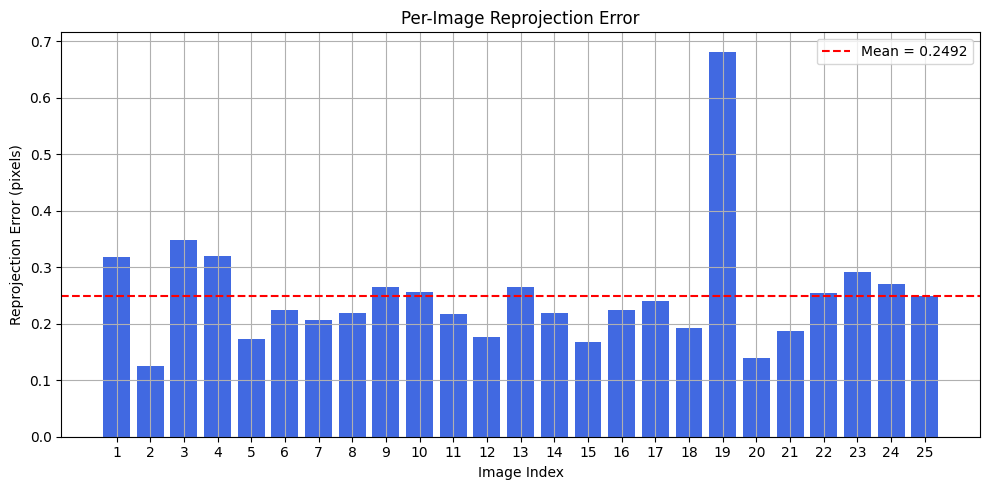

In [8]:
reprojection_errors = []

for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
    reprojection_errors.append(error)

# individual errors
for i, err in enumerate(reprojection_errors):
    print(f"Image {i+1:02d} - Reprojection Error: {err:.4f} pixels")

# mean and standard deviation
mean_error = np.mean(reprojection_errors)
std_error = np.std(reprojection_errors)
print(f"\nMean Reprojection Error: {mean_error:.4f} pixels")
print(f"Standard Deviation: {std_error:.4f} pixels")

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(reprojection_errors)+1), reprojection_errors, color='royalblue')
plt.axhline(mean_error, color='red', linestyle='--', label=f"Mean = {mean_error:.4f}")
plt.title("Per-Image Reprojection Error")
plt.xlabel("Image Index")
plt.ylabel("Reprojection Error (pixels)")
plt.xticks(range(1, len(reprojection_errors)+1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("reprojection_error_plot.png")
plt.show()

# 3.5 - Corners Detected

In [9]:
os.makedirs('reprojection_visuals', exist_ok=True)

for i, file_name in enumerate(images):
    img = cv2.imread(file_name)
    if img is None:
        print(f"Failed to load {file_name}")
        continue

    # Project object points using estimated parameters
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)

    # Draw original detected corners (green) and reprojected corners (red)
    for p1, p2 in zip(imgpoints[i], imgpoints2):
        pt1 = tuple(np.round(p1.ravel()).astype(int))  # Detected
        pt2 = tuple(np.round(p2.ravel()).astype(int))  # Reprojected
        cv2.circle(img, pt1, 4, (0, 255, 0), -1)  # Green
        cv2.circle(img, pt2, 2, (0, 0, 255), -1)  # Red

    # Save image
    out_path = f"reprojection_visuals/reprojection_comparison_{i+1:02d}.jpeg"
    cv2.imwrite(out_path, img)

# 3.6 - Checkerboard Plane Normals

In [10]:
plane_normals = []

for i in range(len(rvecs)):
    R, _ = cv2.Rodrigues(rvecs[i])         # Convert to rotation matrix
    normal_ci = R[:, 2]                    # Third column is the Z-axis of the checkerboard in camera frame
    plane_normals.append(normal_ci)
    print(f"Image {i+1:02d} - Plane Normal (Camera Frame): {normal_ci}")

Image 01 - Plane Normal (Camera Frame): [0.04079217 0.53648296 0.84292469]
Image 02 - Plane Normal (Camera Frame): [-0.06087978  0.59165706  0.80388779]
Image 03 - Plane Normal (Camera Frame): [0.37785269 0.13268537 0.91630887]
Image 04 - Plane Normal (Camera Frame): [-0.43568572  0.62526014  0.64747797]
Image 05 - Plane Normal (Camera Frame): [-0.24641055  0.37073319  0.89545449]
Image 06 - Plane Normal (Camera Frame): [0.38033675 0.64320056 0.66455774]
Image 07 - Plane Normal (Camera Frame): [-0.05397362  0.20087913  0.97812802]
Image 08 - Plane Normal (Camera Frame): [0.27481746 0.71103838 0.64722468]
Image 09 - Plane Normal (Camera Frame): [-0.09064862  0.72586098  0.68184211]
Image 10 - Plane Normal (Camera Frame): [0.14050772 0.32569077 0.9349776 ]
Image 11 - Plane Normal (Camera Frame): [0.11688001 0.56613103 0.81598696]
Image 12 - Plane Normal (Camera Frame): [-0.0470609   0.03257829  0.99836062]
Image 13 - Plane Normal (Camera Frame): [-0.14823305  0.41211664  0.89899212]
Imag